In [25]:
import numpy as np
import pandas as pd
import sklearn
from pathlib import Path
import matplotlib.pyplot as plt
import re
from utils import *

pd.set_option('future.no_silent_downcasting', True)

# Read target data

In [26]:
path_data = Path("../data")

In [27]:
_anomaly_data = pd.read_csv(path_data / "для анализа/dataset._anomaly.csv", sep=";", low_memory=False)
_normal_data = pd.read_csv(path_data / "для анализа/dataset._normal.csv", sep=";", low_memory=False)
_problems_data = pd.read_csv(path_data / "для анализа/dataset._problems.csv", sep=";", low_memory=False)

# EDA

In [28]:
anomaly_data = _anomaly_data.copy()
normal_data = _normal_data.copy()
problems_data = _problems_data.copy()

In [29]:
datasets = [anomaly_data, normal_data, problems_data]

In [30]:
for dataset in datasets:
    dataset.drop(cols_to_remove, axis=1, inplace=True)

In [31]:
normal_data["target"] = 0
anomaly_data["target"] = 1
problems_data["target"] = 2
all_data = pd.concat([normal_data, anomaly_data, problems_data], axis=0, ignore_index=True)

print(all_data.shape)

fill_space_with_nans(all_data)
all_data = remove_null_ros(all_data)

print(all_data.shape)

(3345794, 12)
(2856565, 12)


In [32]:
all_data.head(3)

,"Полож.пед.акселер.,%","Давл.масла двиг.,кПа","Обор.двиг.,об/мин",КПП. Давление масла в системе смазки,Скорость,ДВС. Давление смазки,ДВС. Температура охлаждающей жидкости,"Давление в пневмостистеме (spn46), кПа",Электросистема. Напряжение,ДВС. Частота вращения коленчатого вала,Дата и время,target
384,"0,0",0,"0,000",NaN,0,0,35,NaN,NaN,0,01/06/2023 07:57:01,0
386,"0,0",380,"649,000",1184,0,380,34,760,27.2,649,01/06/2023 07:57:31,0
387,"0,0",360,"651,000",1200,0,360,34,816,28.05,651,01/06/2023 07:58:01,0


In [33]:
for col in brake_int_cols:
    all_data[col] = all_data[col].str.replace(",", ".")

In [34]:
all_data.head(3)

,"Полож.пед.акселер.,%","Давл.масла двиг.,кПа","Обор.двиг.,об/мин",КПП. Давление масла в системе смазки,Скорость,ДВС. Давление смазки,ДВС. Температура охлаждающей жидкости,"Давление в пневмостистеме (spn46), кПа",Электросистема. Напряжение,ДВС. Частота вращения коленчатого вала,Дата и время,target
384,0.0,0,0.000,NaN,0,0,35,NaN,NaN,0,01/06/2023 07:57:01,0
386,0.0,380,649.000,1184,0,380,34,760,27.2,649,01/06/2023 07:57:31,0
387,0.0,360,651.000,1200,0,360,34,816,28.05,651,01/06/2023 07:58:01,0


In [35]:
for num_col in numeric_cols:
    all_data[num_col] = all_data[num_col].astype(float)

In [36]:
all_data["Дата и время"] = pd.to_datetime(all_data["Дата и время"], format='%d/%m/%Y %H:%M:%S', dayfirst=True )

## Description

In [37]:
all_data.head()

,"Полож.пед.акселер.,%","Давл.масла двиг.,кПа","Обор.двиг.,об/мин",КПП. Давление масла в системе смазки,Скорость,ДВС. Давление смазки,ДВС. Температура охлаждающей жидкости,"Давление в пневмостистеме (spn46), кПа",Электросистема. Напряжение,ДВС. Частота вращения коленчатого вала,Дата и время,target
384,0.0,0.0,0.000,NaN,0.0,0.0,35.0,NaN,NaN,0.000,2023-06-01 07:57:01,0
386,0.0,380.0,649.000,1184.0,0.0,380.0,34.0,760.0,27.20,649.000,2023-06-01 07:57:31,0
387,0.0,360.0,651.000,1200.0,0.0,360.0,34.0,816.0,28.05,651.000,2023-06-01 07:58:01,0
388,0.0,348.0,656.000,1200.0,0.0,348.0,35.0,816.0,28.10,656.000,2023-06-01 07:58:31,0
389,0.0,360.0,671.875,1200.0,0.0,360.0,36.0,816.0,28.10,671.875,2023-06-01 07:59:01,0


In [38]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2856565 entries, 384 to 3345793
Data columns (total 12 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   Полож.пед.акселер.,%                    float64       
 1   Давл.масла двиг.,кПа                    float64       
 2   Обор.двиг.,об/мин                       float64       
 3   КПП. Давление масла в системе смазки    float64       
 4   Скорость                                float64       
 5   ДВС. Давление смазки                    float64       
 6   ДВС. Температура охлаждающей жидкости   float64       
 7   Давление в пневмостистеме (spn46), кПа  float64       
 8   Электросистема. Напряжение              float64       
 9   ДВС. Частота вращения коленчатого вала  float64       
 10  Дата и время                            datetime64[ns]
 11  target                                  int64         
dtypes: datetime64[ns](1), float64(10), int64(1)
m

In [39]:
all_data.describe()

,"Полож.пед.акселер.,%","Давл.масла двиг.,кПа","Обор.двиг.,об/мин",КПП. Давление масла в системе смазки,Скорость,ДВС. Давление смазки,ДВС. Температура охлаждающей жидкости,"Давление в пневмостистеме (spn46), кПа",Электросистема. Напряжение,ДВС. Частота вращения коленчатого вала,Дата и время,target
count,2.812354e+06,2.811995e+06,2.808830e+06,2.653296e+06,2.702376e+06,2.811994e+06,2.806123e+06,2.673350e+06,2.302954e+06,2.813049e+06,2856565,2.856565e+06
mean,3.500577e+01,4.431452e+02,1.660802e+03,1.215212e+03,6.657186e+00,4.465779e+02,7.541672e+01,7.442729e+02,2.611713e+01,1.660409e+03,2023-07-08 22:52:37.891063296,1.573102e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2023-04-26 08:18:36,0.000000e+00
25%,0.000000e+00,3.680000e+02,1.303500e+03,1.200000e+03,0.000000e+00,3.680000e+02,7.300000e+01,7.280000e+02,2.760000e+01,1.303500e+03,2023-06-11 09:46:40,2.000000e+00
50%,0.000000e+00,4.680000e+02,1.887000e+03,1.216000e+03,6.500000e+00,4.680000e+02,7.600000e+01,7.600000e+02,2.790000e+01,1.887000e+03,2023-07-08 14:49:13,2.000000e+00
75%,9.480000e+01,5.080000e+02,1.905000e+03,1.264000e+03,1.040000e+01,5.080000e+02,7.800000e+01,7.840000e+02,2.810000e+01,1.904125e+03,2023-08-05 11:47:18,2.000000e+00
max,1.000000e+02,1.500000e+03,5.000000e+03,3.000000e+03,3.860000e+01,1.600000e+03,1.500000e+02,1.000000e+03,3.060000e+01,5.000000e+03,2023-10-13 09:28:18,2.000000e+00
std,4.239520e+01,1.806461e+02,6.227866e+02,2.978850e+02,7.614724e+00,1.914539e+02,1.260560e+01,1.098635e+02,5.290434e+00,6.220910e+02,NaN,7.779104e-01


In [40]:
all_data.nunique()

Полож.пед.акселер.,%                          298
Давл.масла двиг.,кПа                         1501
Обор.двиг.,об/мин                           15532
КПП. Давление масла в системе смазки         3001
Скорость                                      597
ДВС. Давление смазки                         1601
ДВС. Температура охлаждающей жидкости         151
Давление в пневмостистеме (spn46), кПа        979
Электросистема. Напряжение                    258
ДВС. Частота вращения коленчатого вала      15579
Дата и время                              2522344
target                                          3
dtype: int64

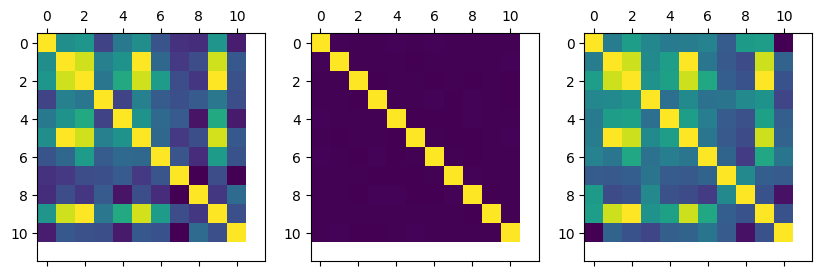

In [41]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
for i in range(3):
    axis[i].matshow(all_data[all_data["target"] == i].corr())


In [42]:
pd.to_pickle(all_data, path_data / "analysis_with_nan.pickle")

## Fill nans

In [43]:
all_data.sort_values(["target", "Дата и время"], inplace=True, ignore_index=True)

In [44]:
all_data.bfill(inplace=True)
all_data.ffill(inplace=True)

In [45]:
all_data.isna().sum()

Полож.пед.акселер.,%                      0
Давл.масла двиг.,кПа                      0
Обор.двиг.,об/мин                         0
КПП. Давление масла в системе смазки      0
Скорость                                  0
ДВС. Давление смазки                      0
ДВС. Температура охлаждающей жидкости     0
Давление в пневмостистеме (spn46), кПа    0
Электросистема. Напряжение                0
ДВС. Частота вращения коленчатого вала    0
Дата и время                              0
target                                    0
dtype: int64

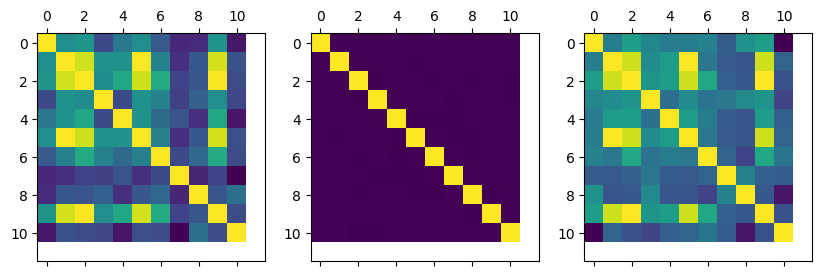

In [46]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
for i in range(3):
    axis[i].matshow(all_data[all_data["target"] == i].corr())

In [47]:
pd.to_pickle(all_data, path_data / "analysis_clear.pickle")


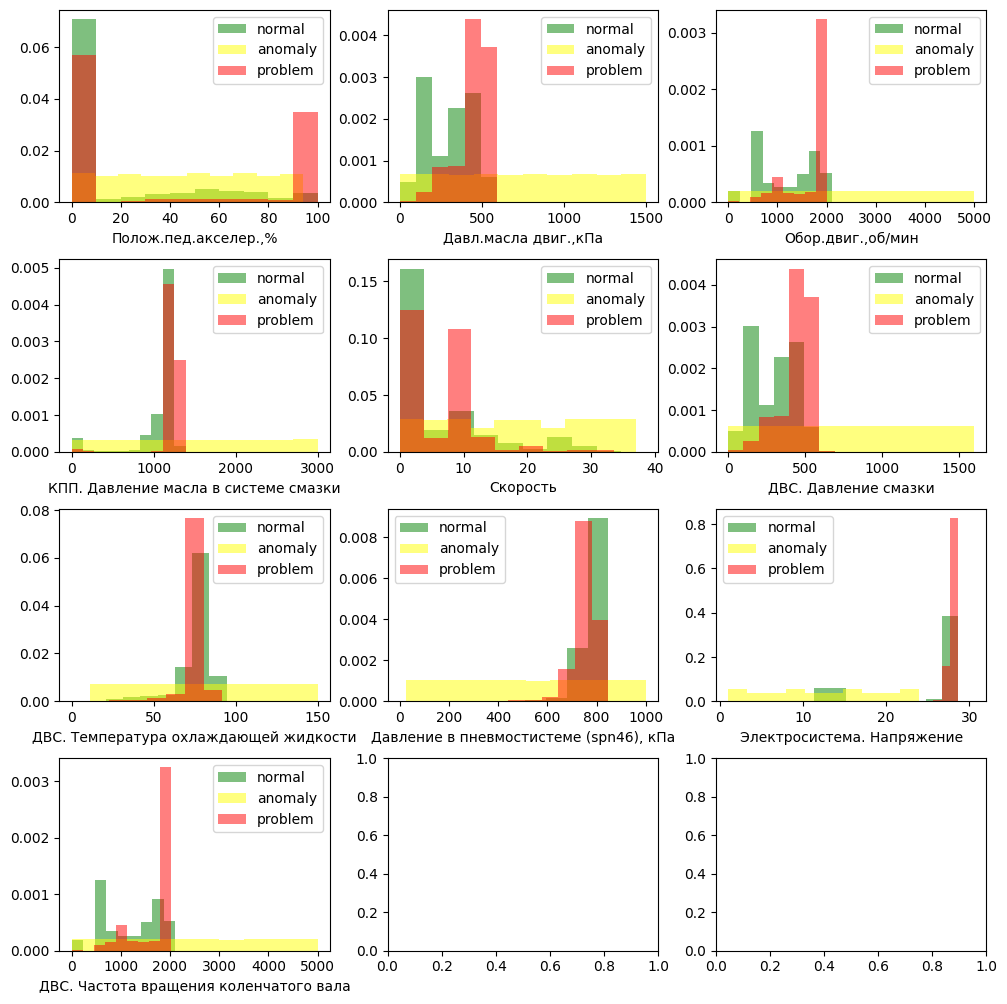

In [48]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(10,10))
fig.tight_layout(h_pad=2)

for i, num_col in enumerate(numeric_cols):
    row = i // 3
    col = i % 3
    df_target_0 = all_data.loc[all_data["target"] == 0, num_col]
    df_target_1 = all_data.loc[all_data["target"] == 1, num_col]
    df_target_2 = all_data.loc[all_data["target"] == 2, num_col]
    axis[row][col].hist(df_target_0, alpha=0.5, label="normal", density=True, color="green")
    axis[row][col].hist(df_target_1, alpha=0.5, label="anomaly", density=True, color="yellow")
    axis[row][col].hist(df_target_2, alpha=0.5, label='problem', density=True, color="red")
    axis[row][col].legend()
    axis[row][col].set_xlabel(num_col)